# EDA в NLP

## Зависимости

In [ ]:
!pip install datasets==2.1.0 seaborn==0.11.2 scikit-learn==1.0.2 gensim==4.2.0 nltk==3.7 pymystem3==0.2.0 pyLDAvis==3.3.1

     |████████████████████████████████| 325 kB 4.3 MB/s 
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
     |████████████████████████████████| 1.5 MB 36.7 MB/s 
     |████████████████████████████████| 1.7 MB 41.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 212 kB 52.4 MB/s 
     |████████████████████████████████| 1.1 MB 9.8 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 136 kB 53.9 MB/s 
     |████████████████████████████████| 749 kB 49.5 MB/s 
     |████████████████████████████████| 127 kB 49.0 MB/s 
     |████████████████████████████████| 144 kB 50.9 MB/s 
     |████████████████████████████████| 271 kB 56.6 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136

In [ ]:
!python -m nltk.downloader stopwords

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

from datasets import load_dataset
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from string import punctuation

#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

nltk.download("stopwords")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Статистика по датасету

In [ ]:
# Загружаем датасет

dataset = load_dataset("blinoff/kinopoisk")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset kinopoisk downloaded and prepared to /root/.cache/huggingface/datasets/blinoff___kinopoisk/simple/1.0.0/62f52027aea59f64f49c7b16165b82cb4dc45031bad3660c2719bf2a6ea4a44e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['content', 'title', 'grade3', 'movie_name', 'part', 'review_id', 'author', 'date', 'grade10', 'Idx'],
        num_rows: 36591
    })
    validation: Dataset({
        features: ['content', 'title', 'grade3', 'movie_name', 'part', 'review_id', 'author', 'date', 'grade10', 'Idx'],
        num_rows: 36591
    })
})

In [ ]:
i = np.random.randint(0, len(dataset["train"]))

print(dataset["train"][i]["movie_name"], dataset["train"][i]["grade3"])
print(dataset["train"][i]["content"])


Форрест Гамп (1994) Good

Смотрю этот фильм в 7 раз и не теряю к нему интереса, а на оборот, каждый раз открываю для себя что-то новое в нём. Начинаю замечать существенные мелочи, которых раньше не видела. И с каждым разом любовь к этому фильму растёт.

О чём же этот фильм? Просто о жизни необычного человека или же здесь кроется более глубокий смысл? По крайней мере, я увидела множество моментов, которые заставили меня задуматься над жизнью.

Главный вопрос фильма: есть у нас судьба или мы все-таки летим по жизни, как пёрышко? Я и раньше задумывалась над этим, но не находила ответа. Но, посмотрев это фильм — нашла. Теперь я думаю, что всё-таки мы летим, а судьба время от времени предоставляет нам шансы — более короткие пути к счастью и успеху, и тогда уже мы выбираем, воспользоваться этим шансом или нет.

Однажды я услышала: «Этот фильм о каком-то дурачке»

Я не считаю Форреста дураком. Да, у него невысокое IQ. Да, он немного заторможен. Но он не дурак. Разве дурак стал бы миллионером?

## Предобработка

In [ ]:
russian_stopwords

In [ ]:
mystem = Mystem() 

### Стемминг

In [ ]:
stemmer = SnowballStemmer("russian") 


def stem_text(text):
    tokens = text.lower()
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    tokens = text.lower().split()
    
    return " ".join(list(map(stemmer.stem, tokens)))

stem_text("Ну что сказать, я вижу кто-то наступил на грабли, Ты разочаровал меня, ты был натравлен.")

'ну что сказать, я виж кто-т наступ на грабли, ты разочарова меня, ты был натравлен.'

### Лемматизация

In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 8.2 MB 6.2 MB/s 


In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer() 


'наступить'

In [ ]:
# %%timeit
def lemmatize_text(text):
    tokens = list(map(lambda t: morph.parse(t)[0].normal_form, text.split()))
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

lemmatize_text("Ну что сказать, я вижу кто-то наступил на грабли, Ты разочаровал меня, ты был натравлен.")

'сказать, видеть кто-то наступить грабли, разочаровать меня, натравлен.'

In [ ]:
from typing import List

def flatten(sentences: List[List[str]]) -> List[str]:
    result = []
    for sentence in sentences:
        result += sentence
    return result

words = flatten(map(lambda text: text.split(), dataset['train']["content"]))
n_words = len(words)
n_unique_words = len(set(words))

print("{:,} кол-во примеров".format(len(dataset["train"])))
print("{:,} слов".format(n_words))
print("{:,} уникальных слов".format(n_unique_words))

36,591 кол-во примеров
10,828,591 слов
632,527 уникальных слов


In [ ]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# TODO: вывести кол-во уникальных лемматизированных слов

import tqdm
cache = {}

def lemmatize_text(text):
    tokens = []
    for punkt in punctuation:
      text = text.replace(punkt, "")

    for word in text.split():
      if word not in cache:
        cache[word] = morph.parse(word)[0].normal_form
      tokens.append(cache[word])
    
    text = " ".join(tokens)
    
    return text

lemmatized = list(
    tqdm.tqdm(map(lemmatize_text, dataset['train']["content"]),
              total=len(dataset['train'])))

100%|██████████| 36591/36591 [01:38<00:00, 372.63it/s]


In [ ]:
lemmatized[0]

'блеф» — один из мой самый любимый комедия этот фильм я наверно смотреть раз сто нет я конечно блефовать я видеть он куда большой не мочь не выразить свой восхищение главный действовать лицо это фильм начать с адриано челентано для который как я считать это хороший роль в кино великолепный актёр неплохой певец странно что на он родина в италия он песня мало кто слушать ну я думать что и итальянец и француз привыкнуть к тот что у мы до сей они актёр популярный чем даже на свой родина да такой вот парадокс челентано конечно профессионал свой дело комик с серьёзный выражение лицо он смешной ещё и потому что одновременно так серъёзный адриано браво а теперь несколько слово о энтони куиня да тот самый горбун из нотрдама собор парижский богоматерь оригинальный версия кто не смотреть рекомендовать с они както приключиться один интересный история на съёмка один из свой фильм он то ли сломать то ли подвихнуть нога а роль требовать от он чтобы в один из сцена он кружиться с дама в танец и он вме

In [ ]:
import tqdm

def lemmatize_text(text):
    tokens = []
    for punkt in punctuation:
      text = text.replace(punkt, "")
    for word in text.split():
      tokens.append(morph.parse(word)[0].normal_form)
    
    text = " ".join(tokens)
    
    return text

slow_lemmatized = list(
    tqdm.tqdm(map(lemmatize_text, dataset['train']["content"]),
              total=len(dataset['train'])))

  3%|▎         | 1158/36591 [01:23<42:32, 13.88it/s]


KeyboardInterrupt: ignored

## Визуализация

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


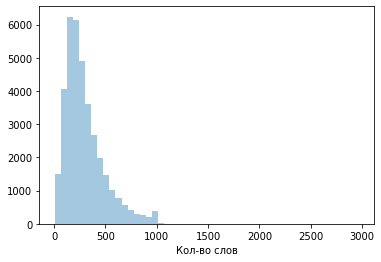

In [ ]:
import pandas as pd
sentences_length_list = list(map(lambda text: len(text.split()), dataset['train']["content"]))

sns.distplot(
    pd.Series(sentences_length_list, name="Кол-во слов"),
    label="Распределение кол-ва слов",
    kde=False
)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


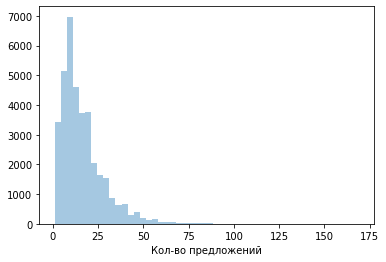

In [ ]:
sentences_count_list = list(map(lambda text: len(text.split(". ")), dataset['train']["content"]))

sns.distplot(
    pd.Series(sentences_count_list, name="Кол-во предложений"),
    label="Распределение кол-ва слов",
    kde=False
)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


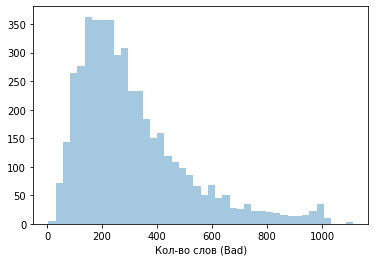

In [ ]:
# TODO: вывести распределение кол-ва слов по каждому классу
df = dataset['train'].to_pandas()[["content", "grade3"]]

sns.distplot(
    pd.Series(df.loc[df["grade3"] == "Bad", "content"].apply(lambda t: len(t.split())),
              name="Кол-во слов (Bad)"),
    label="Распределение кол-ва слов",
    kde=False
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


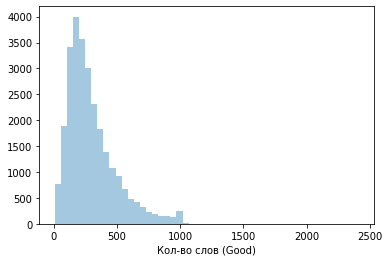

In [ ]:
sns.distplot(
    pd.Series(df.loc[df["grade3"] == "Good", "content"].apply(lambda t: len(t.split())),
              name="Кол-во слов (Good)"),
    label="Распределение кол-ва слов",
    kde=False
)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


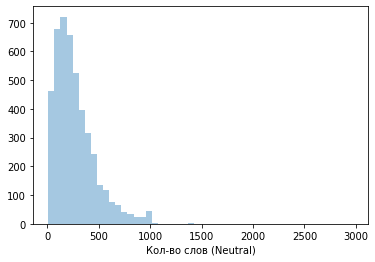

In [ ]:
sns.distplot(
    pd.Series(df.loc[df["grade3"] == "Neutral", "content"].apply(lambda t: len(t.split())),
              name="Кол-во слов (Neutral)"),
    label="Распределение кол-ва слов",
    kde=False
)

## ТОПы

In [ ]:
# Топ 50 часто используемых слов
pd.Series(words).value_counts().head(50)

и          377670
в          263593
не         240093
что        146468
на         132182
—          120114
с           92269
это         76088
как         71226
из          69390
но          60607
я           59880
его         53500
он          52807
а           50195
фильм       49517
все         46143
о           41906
к           39603
10          39005
И           38191
по          38052
за          36481
же          35631
так         35368
очень       35249
бы          32969
от          32709
для         31440
Но          30846
просто      30148
В           29674
то          28229
у           28031
только      27759
этот        24533
даже        23795
А           22634
фильма      21886
который     21777
было        20793
уже         20661
до          20273
меня        19950
можно       19371
Я           19206
или         18640
когда       18454
мне         18303
они         18158
dtype: int64

In [ ]:
# TODO: вывести топ-50 часто используемых слов без учета союзов и предлогов


In [ ]:
df = dataset["train"].to_pandas()

pd.Series(flatten(df.loc[df["grade3"] == "Good", "content"].str.strip().apply(lambda t: t.split()))).value_counts().head()

и      288929
в      198752
не     173323
что    108503
на      96930
dtype: int64

In [ ]:
# TODO: вывести топ уникальных слов для каждого класса

## Наиболее значимые слова

In [ ]:
tfidf = TfidfVectorizer().fit(dataset["train"]["content"])
logreg = LogisticRegression().fit(tfidf.transform(dataset["train"]["content"]), dataset["train"]["grade3"])


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
logreg.coef_.shape, len(tfidf.vocabulary_)


((3, 271614), 271614)

In [ ]:
itos = {i: v for v, i in tfidf.vocabulary_.items()}

In [ ]:
class_index = 0

print("Наиболее значимые слова для класса:", logreg.classes_[class_index])
for i in np.abs(logreg.coef_[class_index]).argsort()[-40:]:
    print("-", itos[i])


Наиболее значимые слова для класса: Bad
- не
- весь
- никак
- ужасно
- главное
- есть
- итоге
- его
- создатели
- немного
- разочарование
- сценарий
- сожалению
- 10
- приятно
- снять
- вместо
- он
- отлично
- снимать
- непонятно
- единственное
- именно
- нет
- мир
- понимаю
- абсолютно
- деньги
- жизни
- видимо
- никакой
- вообще
- жизнь
- из
- каждый
- бред
- ничего
- очень
- увы
- зачем


In [ ]:
# TODO: вывести наиболее значимые слова с лемматизацией

## Тематические модели

In [ ]:

def remove_stop_words(text: List[str]) -> List[str]:
    return [word for word in text if word not in russian_stopwords]


In [ ]:
words = list(map(lambda t: remove_stop_words(t.lower().split()), dataset["train"]["content"]))
dictionary = corpora.Dictionary(words)

In [ ]:
corpus = [dictionary.doc2bow(t) for t in words]

lda_model = LdaModel(
    corpus=corpus, id2word=dictionary, num_topics=3, iterations=100, alpha='auto')

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.015*"—" + 0.013*"это" + 0.007*"фильм" + 0.005*"10" + 0.004*"просто" + '
  '0.003*"который" + 0.003*"жизнь" + 0.003*"то," + 0.003*"которые" + '
  '0.003*"жизни"'),
 (1,
  '0.020*"—" + 0.015*"это" + 0.010*"фильм" + 0.007*"очень" + 0.005*"просто" + '
  '0.005*"10" + 0.004*"фильма" + 0.003*"фильме" + 0.003*"который" + '
  '0.002*"вообще"'),
 (2,
  '0.000*"мультфильм" + 0.000*"—" + 0.000*"это" + 0.000*"«рататуй»" + '
  '0.000*"pixar" + 0.000*"мультфильмы" + 0.000*"мультфильма" + '
  '0.000*"мультфильм," + 0.000*"реми" + 0.000*"просто"')]


In [ ]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.191486 -0.036540       1        1  68.266941
0     -0.075405  0.048931       2        1  31.711513
2      0.266891 -0.012392       3        1   0.021546, topic_info=        Term           Freq          Total Category  logprob  loglift
230    жизнь    7702.000000    7702.000000  Default  30.0000  30.0000
208      это  102812.000000  102812.000000  Default  29.0000  29.0000
229    жизни    7520.000000    7520.000000  Default  28.0000  28.0000
209        —  132784.000000  132784.000000  Default  27.0000  27.0000
1         10   34563.000000   34563.000000  Default  26.0000  26.0000
..       ...            ...            ...      ...      ...      ...
128   просто       0.078200   34769.548841   Topic3  -9.9091  -4.5622
1         10       0.077548   34563.250554   Topic3  -9.9175  -4.5647
108    очень       0.076627   38912.501317   Topic3  -9.9294  -4.6951
197    фильм       0.050342   66043.017285   Topic3 -10.3495  -5.6442
626  который       0.039815   20559.710717   Topic3 -10.5841  -4.7118

[311 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
469332      2  1.079764  ("смывайся»
4369        1  0.964820            1
4369        2  0.035013            1
1           1  0.655436           10
1           2  0.344557           10
...       ...       ...          ...
618         2  0.018750         юмор
5379        1  0.954236         явно
5379        2  0.045732         явно
209         1  0.746909            —
209         2  0.253087            —

[490 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])